Get Data From Drive

In [0]:
%%capture

fileid='1FUZJECbq2GSXnzoBXpptz0-3IapCXUKx'
filename='emotion.zip'

#https://drive.google.com/open?id=1FUZJECbq2GSXnzoBXpptz0-3IapCXUKx

! wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id={fileid}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt

! wget --load-cookies cookies.txt -O {filename} 'https://docs.google.com/uc?export=download&id='{fileid}'&confirm='$(<confirm.txt)

In [0]:
! unzip -q -n emotion.zip

In [0]:
# pip install librosa

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import librosa
from fastai.vision import *
from IPython.display import Audio
import librosa.display

Test on how the data would look as a mel spectrogram

In [0]:
clip, sample_rate = librosa.load('/content/meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav', sr=None)
# clip = clip[:132300] # first three seconds of file

In [0]:
sample_rate

16000

In [0]:
clip

array([ 2.593994e-04,  1.525879e-05,  4.577637e-05,  3.509521e-04, ...,  1.525879e-05, -3.204346e-04, -2.593994e-04,
       -2.136230e-04], dtype=float32)

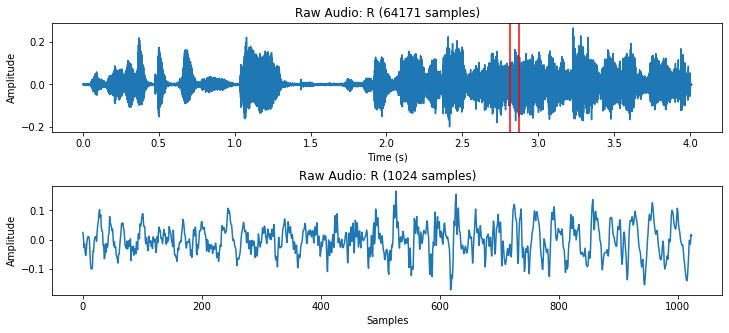

In [0]:
timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format("R", len(clip)))


n_fft = 1024 # frame length 
start = 45000 # start at a part of the sound thats not silence.. 
x = clip[start:start+n_fft]

# mark location of frame in the entire signal
ax[0].axvline(start/sample_rate, c='r') 
ax[0].axvline((start+n_fft)/sample_rate, c='r')

# plot N samples 
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio: {} ({} samples)'.format("R", len(x)));

In [0]:
Audio(clip, rate=sample_rate)


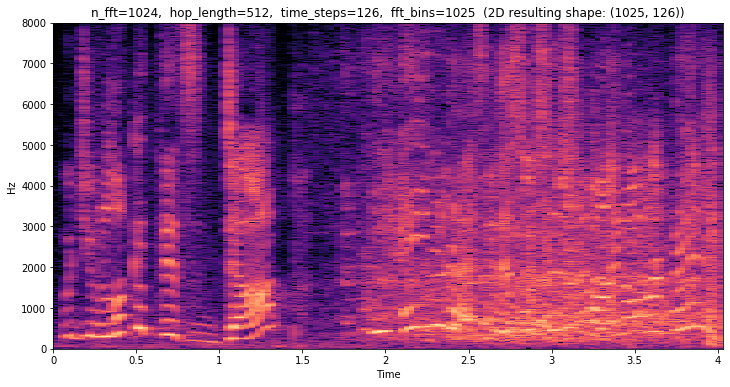

In [0]:
hop_length = 512
stft = librosa.stft(clip, n_fft=2048, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


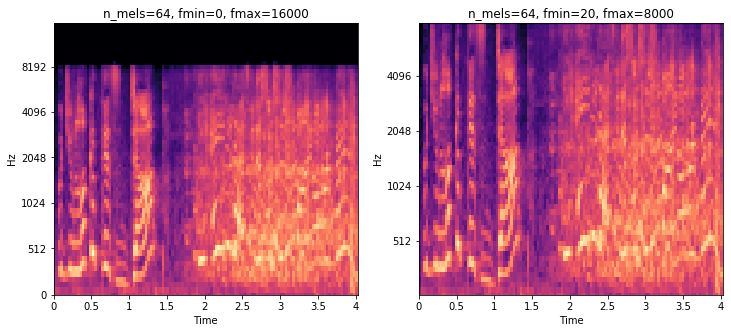

In [0]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = 16000 # sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title('n_mels=64, fmin=0, fmax=16000')

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels=64, fmin=20, fmax=8000')

plt.show()

In [0]:
print(clip.shape)
clip2 = tensor(clip).cuda()
print(clip2.device)
torch.stft(tensor(clip), 1024,94).device

(64171,)
cuda:0


device(type='cpu')

In [0]:
# def convert_to_spectrogram()

Code to convert the audio files into Mel Spectrograms

In [0]:
data_path = Path('/content/meld_image_data2') 
# os.mkdir(data_path/'train')
# labels = 
def create_fold_directory(folder_name):
    audio_files_dir = Path('meld')/folder_name

    for label in list(audio_files_dir.glob('*')):
        label_str = label.as_posix().split('/')[-1]
        audio_files = list(Path(label).glob('*.wav'))
        print(label_str)
        os.makedirs(data_path/folder_name/label_str, exist_ok=True)

        for audio_file in audio_files:
            samples, sample_rate = librosa.load(audio_file, res_type='kaiser_fast',duration=6,sr=16000*2)
             
            fig = plt.figure(figsize=[0.8,0.8])
            ax = fig.add_subplot(111)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            filename  = data_path/folder_name/label_str/Path(audio_file).name.replace('.wav','.png')
            S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_fft=512, hop_length=160,
                                                    n_mels=64,fmin=0, fmax=sample_rate//2)
            librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
            plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
            # print(filename)
            plt.close('all')

create_fold_directory('train')
create_fold_directory('val')

neutral
neutral


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ! cp -r meld_image_data 'drive/My Drive/data'

# saving data in google drive

In [0]:
path = Path('drive/My Drive/data')
path

PosixPath('drive/My Drive/data')

In [0]:
bs = 64

In [0]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0, max_warp=0)
data = ImageDataBunch.from_folder(path,valid='val',ds_tfms=tfms,bs=bs)

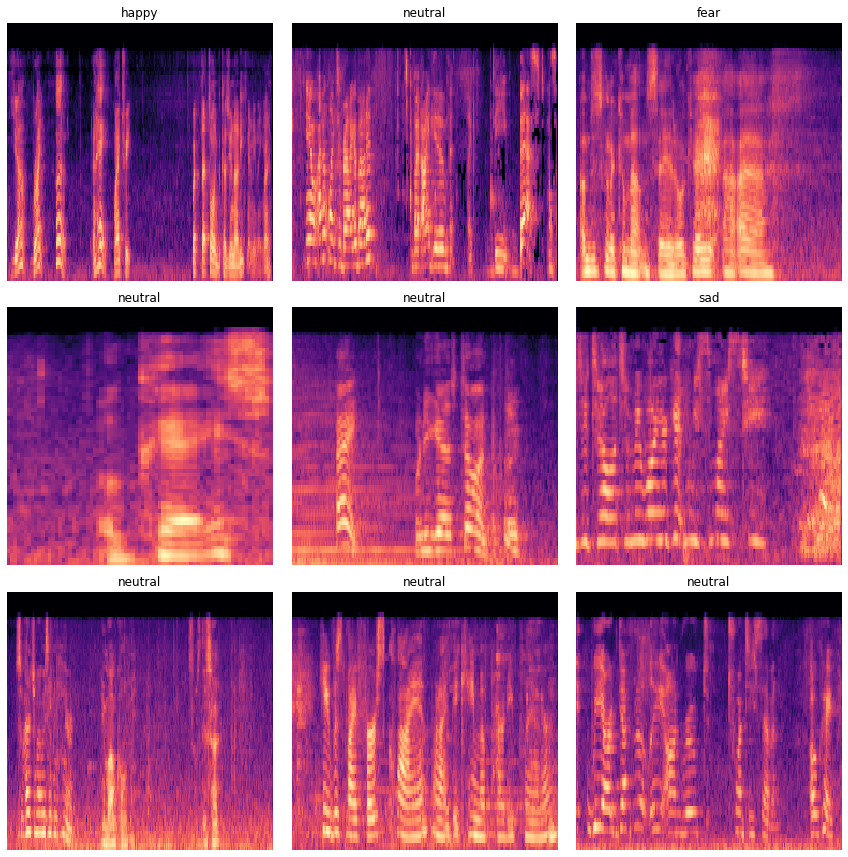

In [0]:
data.show_batch(rows = 3, fig_size = (7,7))

In [0]:
data.c, data.classes

(5, ['disgust', 'fear', 'happy', 'neutral', 'sad'])

In [0]:
data.train_ds[640]

(Image (3, 241, 248), Category neutral)

(array([ 230.,    0.,  213.,    0.,    0., 1597.,    0., 4554.,    0.,  702.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

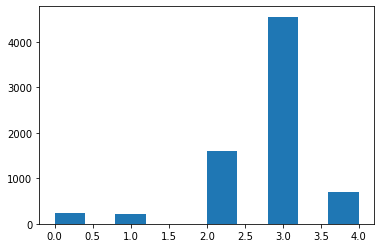

In [0]:
labels = []
for img,target in data.train_dl:
    labels.append(target)
labels = torch.cat(labels)
plt.hist(labels)

In [0]:
ds,dl = data.train_ds,data.train_dl
labels = ds.y.items
_,label_counts = np.unique(labels,return_counts=True)
weights = torch.DoubleTensor((1/label_counts)[labels])
total_len_oversample = int(data.c*np.max(label_counts))
sampler = WeightedRandomSampler(weights, total_len_oversample)
data.train_dl = dl.new(shuffle=False, sampler=sampler)

(array([4603.,    0., 4583.,    0.,    0., 4557.,    0., 4501.,    0., 4668.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

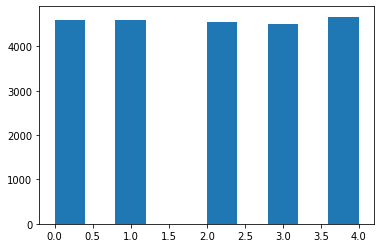

In [0]:
labels = []
for img,target in data.train_dl:
    labels.append(target)
labels = torch.cat(labels)
plt.hist(labels)

In [0]:
# def _plot(i,j,ax):
#     x,y = data.train_ds[3]
#     x.show(ax, y=y)

# plot_multi(_plot, 3, 3, figsize=(12,12))

In [0]:
data.batch_size

128

**Resnet 34 Model**

In [0]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True, callback_fns = [partial(OverSamplingCallback)] )

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


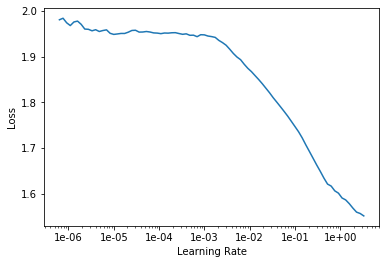

In [0]:
learn.recorder.plot()

Resnet 34, bs =64
Not generalizing well, valid_loss>train_loss

In [0]:
# learn.fit_one_cycle(5, 1e-1)

epoch,train_loss,valid_loss,error_rate,time
0,1.157623,1.180596,0.448193,01:06
1,1.068790,1.100919,0.432530,01:04
2,1.053129,1.103678,0.421687,01:03
3,1.044293,1.056029,0.368675,01:03
4,1.019638,1.059466,0.383133,01:03


bs = 128

In [0]:
learn.fit_one_cycle(5, 5e-1)

epoch,train_loss,valid_loss,error_rate,time
0,1.190896,1.115878,0.377108,02:12
1,1.114443,1.086521,0.377108,01:00
2,1.086569,1.110997,0.374699,01:00
3,1.073415,1.072799,0.377108,00:59
4,1.065158,1.068538,0.377108,00:59


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


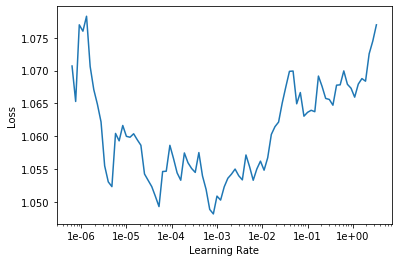

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.055798,2.303659,0.380723,01:22
1,1.053761,2.369815,0.377108,01:22
2,1.053696,1.067762,0.379518,01:22
3,1.046814,1.076345,0.375904,01:22
4,1.043851,1.060948,0.381928,01:22


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


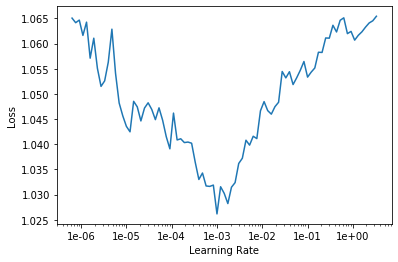

In [0]:
learn.lr_find(wd=0.6)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


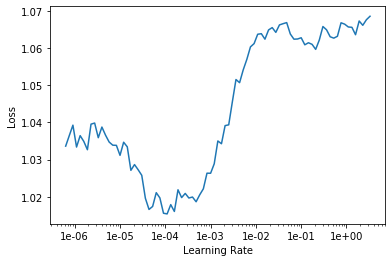

In [0]:
learn.lr_find(wd=0.2)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


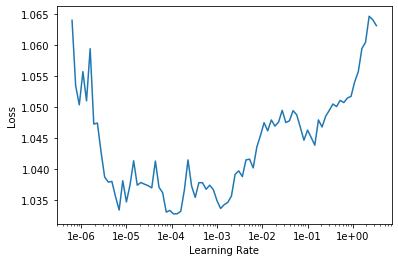

In [0]:
learn.lr_find(wd=1e-2)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


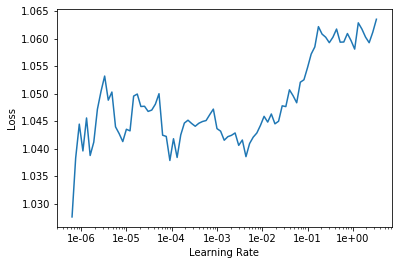

In [0]:
learn.lr_find(wd=1e-4)
learn.recorder.plot()

After Oversampling data


In [0]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy], bn_final=True, callback_fns = [callbacks.OverSamplingCallback] )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


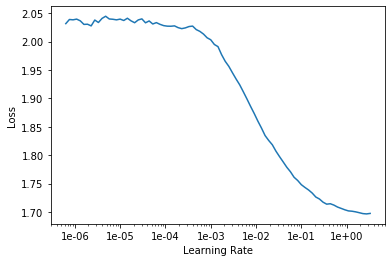

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, 1e-1/2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.204302,2.216305,0.932530,0.067470,02:58
1,1.136964,1.893338,0.816867,0.183133,02:57
2,1.146607,1.686823,0.648193,0.351807,02:56
3,0.861843,2.683838,0.768675,0.231325,02:56
4,0.695109,1.494578,0.610843,0.389157,02:56
5,0.499085,1.555702,0.610843,0.389157,02:56
6,0.419082,1.460559,0.546988,0.453012,02:56


In [0]:
learn.save('model2-stage-1-res-34')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 5.75E-07


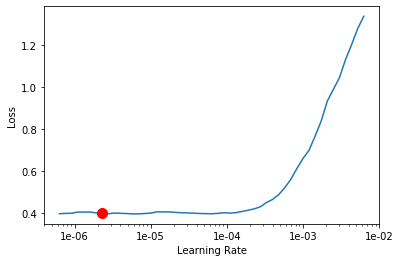

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(7, slice(1e-5/2, 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.372116,1.565046,0.606024,0.393976,04:07
1,0.337179,1.505499,0.597590,0.402410,04:07
2,0.265859,1.461894,0.537349,0.462651,04:07
3,0.161167,1.475963,0.485542,0.514458,04:07
4,0.094424,1.465334,0.430120,0.569880,04:07
5,0.059664,1.470041,0.445783,0.554217,04:07
6,0.050348,1.483804,0.442169,0.557831,04:07


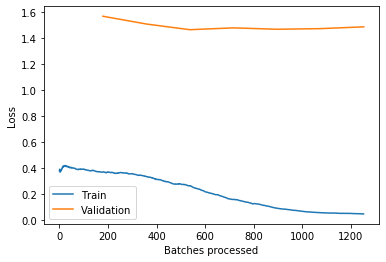

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('model2-stage-2-res-34')

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 7.59E-08


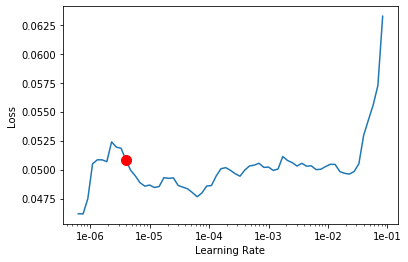

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Way too Overfitting

*abandon model*

[8 9]
16000 (64171, 2)
4.0106875


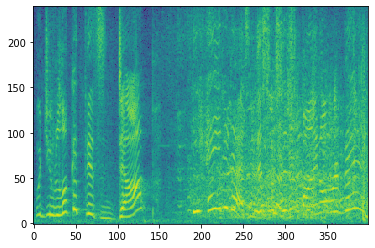

In [0]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('meld/train/disgust/MEL_dia1000_utt0_negative_DIS.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
print(x[:][0])
print(sr, x.shape)
print(x.shape[0]/sr)
window = np.hamming(nwin)

nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )
x = np.transpose(x)[0]

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [0]:
data_path = Path('/content/meld_image_data2') 
# os.mkdir(data_path/'train')
# labels = 
def create_fold_directory(folder_name):
    audio_files_dir = Path('meld')/folder_name

    for label in list(audio_files_dir.glob('*'))[:1]:
        label_str = label.as_posix().split('/')[-1]
        audio_files = list(Path(label).glob('*.wav'))
        print(label_str)
        os.makedirs(data_path/folder_name/label_str, exist_ok=True)

        for audio_file in audio_files[:5]:
            samples, sample_rate = librosa.load(audio_file, res_type='kaiser_fast',duration=5,sr=16000*2)
            print(samples.shape, sample_rate)
            sample_rate = np.array(sample_rate)
            mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=13), axis=0)

            print(mfccs.shape)
create_fold_directory('train')
create_fold_directory('val')

neutral
(160000,) 32000
(313,)
(6144,) 32000
(13,)
(69632,) 32000
(137,)
(160000,) 32000
(313,)
(62806,) 32000
(123,)
neutral
(63488,) 32000
(125,)
(76458,) 32000
(150,)
(45738,) 32000
(90,)
(81920,) 32000
(161,)
(76458,) 32000
(150,)


In [0]:
df = pd.DataFrame(columns=['feature', 'label'])

def create_fold_directory(folder_name):
    audio_files_dir = Path('meld')/folder_name
    bookmark=0
    duration = 6
    for label in list(audio_files_dir.glob('*')):
        label_str = label.as_posix().split('/')[-1]
        audio_files = list(Path(label).glob('*.wav'))
        print(label_str)

        for audio_file in audio_files:
            samples, sample_rate = librosa.load(audio_file, res_type='kaiser_fast',duration=duration,sr=16000*2)
            # print(samples.shape, sample_rate)
            samples = np.concatenate([samples, np.zeros(duration*sample_rate-samples.shape[0])])
            # print(samples.shape)
            sample_rate = np.array(sample_rate)
            mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=13), axis=0)

            df.loc[bookmark] = [mfccs, label_str]
            bookmark=bookmark+1
            # print(mfccs.shape)
create_fold_directory('val')


neutral
happy
disgust
sad
fear


In [0]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df2 = pd.DataFrame(df['feature'].values.tolist())
df3['label'] = df['label']

In [0]:
df3 = pd.read_csv('drive/My Drive/data/features_1.csv')
df3.drop([df3.columns[0]], axis=1, inplace=True)

In [0]:
df3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,label
0,-5.418306,-5.773633,-4.891857,-4.198621,-3.791199,-2.867755,-3.541207,-3.396383,-5.503175,-8.443053,-7.758391,-7.934467,-8.148341,-3.468208,-2.334262,-3.844219,-4.338733,-5.518207,-6.409092,-7.324468,-8.763081,-8.296153,-6.072672,-4.404155,-6.576730,-7.184701,-5.993647,-5.508654,-7.653748,-8.150634,-11.616783,-14.422388,-14.006894,-12.903657,-8.308868,-7.244265,-8.671914,-10.135490,-10.163840,-10.272680,...,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,-50.146407,neutral
1,-16.818974,-19.477208,-21.981554,-21.312483,-23.687432,-24.043684,-22.342479,-21.947107,-22.382512,-22.453812,-21.850074,-24.373799,-27.374853,-25.654112,-24.722725,-26.866344,-27.714467,-28.698760,-27.027770,-25.496412,-25.780548,-27.115418,-28.054951,-29.946962,-28.036764,-25.482012,-24.290835,-25.578411,-26.250779,-26.687628,-26.119732,-22.312108,-20.343772,-19.143335,-19.466459,-21.454329,-23.326532,-22.285033,-21.304097,-19.056607,...,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,-54.593028,neutral
2,-28.300916,-27.437249,-26.987622,-24.847655,-22.266620,-21.068223,-19.957152,-18.994098,-17.867868,-18.555809,-17.657859,-16.466837,-17.612849,-18.324034,-16.903101,-16.280560,-15.931827,-15.644654,-16.345440,-16.566684,-17.074356,-17.795316,-17.035151,-16.355172,-16.187377,-17.805124,-17.932554,-19.103003,-19.728503,-18.459936,-18.732224,-18.395244,-18.415391,-20.174372,-22.481396,-24.520441,-24.997566,-26.195995,-27.427141,-26.414476,...,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,-64.283163,neutral
3,-31.476246,-30.974117,-29.901538,-30.326317,-30.048297,-29.321192,-28.918492,-28.837270,-22.815616,-17.046422,-15.328363,-18.330816,-24.496994,-24.838058,-25.988410,-26.107051,-28.181474,-29.423642,-27.414374,-23.079678,-21.992039,-21.725969,-19.814091,-19.704900,-23.005237,-24.379553,-24.600615,-27.217570,-27.202172,-27.047885,-23.964389,-22.067728,-21.116528,-19.785043,-18.587659,-18.871320,-17.988690,-18.738443,-22.273137,-21.238878,...,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,-55.471862,neutral
4,-12.768766,-12.121767,-12.579519,-13.115817,-13.354021,-12.183498,-14.147498,-15.479872,-14.493789,-13.006679,-14.528898,-12.749960,-11.225543,-8.765857,-5.476997,-5.153551,-8.249461,-10.819234,-9.578357,-11.221944,-11.822

In [0]:
neutral_indices = df3[df3.label == 'neutral'].index
print(neutral_indices.shape)
neutral_indices = np.random.choice(neutral_indices,2500,replace=False)
other_indices = df3[df3.label != 'neutral'].index
under_sample_indices = np.concatenate([neutral_indices,other_indices])
df3 = df3.loc[under_sample_indices]

df3.drop(columns=['label']).values.shape
feature_vecs = df3.drop(columns=['label']).values

(4592,)


(array([2500.,    0., 1609.,    0.,    0.,  232.,    0.,  705.,    0.,  216.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

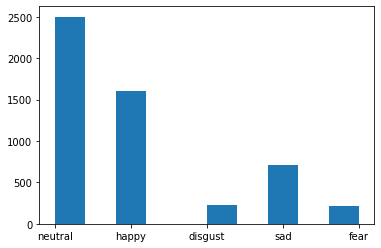

In [0]:
labels = []
for target in df3['label']:
    labels.append(target)
plt.hist(labels)

In [0]:
label_df = pd.DataFrame(df3['label'])
label_df['label'] = pd.Categorical(label_df['label'])
label_df['code'] = label_df['label'].cat.codes

In [0]:
df3.to_csv('drive/My Drive/data/features_1_valid.csv')

In [0]:
import torch.nn as nn

In [0]:
# tmp = df2.values
# train_set = torch.from_numpy(tmp)
train_target = torch.tensor(label_df['code'].values.astype(np.long))
train = torch.tensor(feature_vecs).unsqueeze(dim=1)
train.dtype

torch.float64

In [0]:
feature_vecs = df3.drop(columns=['label']).values

valid_target = torch.tensor(label_df['code'].values.astype(np.long))
valid = torch.tensor(feature_vecs).unsqueeze(dim=1)
valid.dtype

torch.float64

In [0]:
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
data_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 100)

In [0]:
valid_tensor = torch.utils.data.TensorDataset(valid, valid_target) 
valid_data_loader = torch.utils.data.DataLoader(dataset = valid_tensor, batch_size = 900)

AssertionError: ignored

In [0]:
ds,dl = train_tensor,data_loader
labels = label_df['code']
_,label_counts = np.unique(labels,return_counts=True)
weights = torch.DoubleTensor((1/label_counts)[labels])
total_len_oversample = int(5*np.max(label_counts))
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, total_len_oversample)
data_loader = data_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 124, sampler=sampler)

[tensor([4]), tensor([0]), tensor([1]), tensor([1]), tensor([3]), tensor([4]), tensor([0]), tensor([2]), tensor([4]), tensor([0]), tensor([0]), tensor([0]), tensor([3]), tensor([1]), tensor([0]), tensor([2]), tensor([3]), tensor([1]), tensor([0]), tensor([4]), tensor([1]), tensor([1]), tensor([0]), tensor([2]), tensor([3]), tensor([1]), tensor([1]), tensor([3]), tensor([0]), tensor([1]), tensor([2]), tensor([1]), tensor([2]), tensor([2]), tensor([0]), tensor([0]), tensor([2]), tensor([1]), tensor([0]), tensor([3]), tensor([4]), tensor([3]), tensor([4]), tensor([1]), tensor([4]), tensor([2]), tensor([1]), tensor([4]), tensor([4]), tensor([0]), tensor([4]), tensor([2]), tensor([0]), tensor([0]), tensor([1]), tensor([4]), tensor([4]), tensor([4]), tensor([2]), tensor([4]), tensor([2]), tensor([1]), tensor([3]), tensor([2]), tensor([1]), tensor([1]), tensor([1]), tensor([4]), tensor([2]), tensor([2]), tensor([4]), tensor([1]), tensor([2]), tensor([1]), tensor([0]), tensor([0]), tensor([1])

(array([2494.,    0., 2595.,    0.,    0., 2478.,    0., 2448.,    0., 2485.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

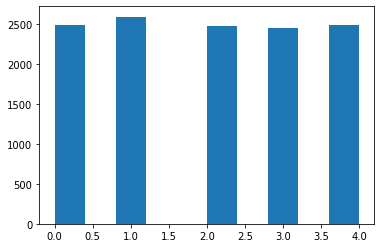

In [0]:
labels = []
for batch in data_loader:
    d, target = batch
    # print(target.shape)
    labels.append(target)

print(labels)
plt.hist(labels)

In [0]:
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(376,150)
        self.linear2 = nn.Linear(150,100)
        self.linear3 = nn.Linear(100,100)
        self.linear4 = nn.Linear(100,100)
        self.linear5 = nn.Linear(100, 5)
        self.act = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax(-1)
    
    def forward(self, x):
        x = x.squeeze()
        # print(x.shape)
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        x = self.act(x)
        x = self.linear3(x)
        x = self.act(x)
        x = self.linear4(x)
        x = self.act(x)
        x = self.linear5(x)
        #x = self.softmax(x)
        # print(x.shape)
        return x

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv1d(in_channels=12, out_channels=24, kernel_size=5, stride=2)
        self.conv4 = nn.Conv1d(in_channels=24, out_channels=36, kernel_size=5, stride=2)
        
        self.fc1 = nn.Linear(in_features=36*4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=5)
        
        
    def forward(self, t):
        t = t
        
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool1d(t, kernel_size=2, stride=2)
        
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool1d(t, kernel_size=2, stride=2)
        
        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool1d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool1d(t, kernel_size=2, stride=2)
        
        # print(t.shape)

        t = t.reshape(-1,36*4)
        #print(t.shape)
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)

        #print(t.shape)
        t = self.fc3(t)
        t = F.relu(t)

        #print(t.shape)
        t = self.fc4(t)
        t = F.relu(t)
        
        t = self.out(t)
        #print(t)
        # print(t.shape)
        #t = F.softmax(t, dim=1)
        return t

In [0]:
network = Network().cuda()
network = network.float()

optimizer = optim.Adam(network.parameters(), lr=1e-2)

images, emo = next(iter(data_loader))

# print(images.dtype)
# print(labels.shape)
images = images.float().cuda()
emo = emo.cuda()

preds = network(images.float())
loss = F.cross_entropy(preds, emo)

loss.backward()
optimizer.step()

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, emo)
print('loss2:', loss.item())

torch.Size([100, 12, 91])
torch.Size([100, 5])
loss1: 2.036447525024414
torch.Size([100, 12, 91])
torch.Size([100, 5])
loss2: 0.0005295848823152483


(array([517.,   0., 181.,   0.,   0.,  28.,   0.,  79.,   0.,  25.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

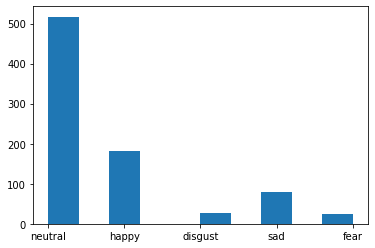

In [0]:
labels = []
for target in df3['label']:
    labels.append(target)

plt.hist(labels)

In [0]:
def get_num_corrects(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def get_all_preds(model, loader):
    total_loss = 0
    total_correct = 0
    total=0
    for batch in loader:
        images, emo = batch
        images = images.float().cuda()
        preds = model(images)

        total += len(images)
        
        emo = emo.cuda()
        loss = F.cross_entropy(preds, emo)

        # print(preds)
        total_loss+=loss.item()
        total_correct += get_num_corrects(preds, emo.cuda())
    

    return total_loss,total_correct/total

In [0]:
network = Network2().cuda()
network = network.float()


def train(epoch=100,lr=0.1):
    # optimizer = optim.Adam(network.parameters(), lr=1e-2)
    optimizer = optim.Adam(network.parameters(), lr=lr, betas=(0.9,0.99), eps=1e-6)
    #optimizer = optim.SGD(network.parameters(), lr=lr, momentum=0.6)
    #optimizer = optim.RMSprop(network.parameters(), lr=lr, alpha=0.99, eps=1e-6)
    for epoch in range(epoch):
        total_loss = 0
        total_correct = 0
        valid_loss = 0

        ct = 0
        for batch in data_loader:
            images, emo = batch

            images = images.float().cuda()
            emo = emo.cuda()

            preds = network(images.float())

            # print(images.shape,preds.shape, emo.shape)
            loss = F.cross_entropy(preds, emo)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            ct+=1
            total_loss+=loss.item()
            total_correct += get_num_corrects(preds, emo.cuda())
        total_loss/=ct

        with torch.no_grad():
            valid_loss, valid_correct = get_all_preds(network, valid_data_loader)

        print('epoch: ', epoch, " total_correct: ", total_correct, " train_loss: ", total_loss, " valid_loss: ", valid_loss, " valid_correct: ", valid_correct,"\n")

In [0]:
train(200,0.01)
# train(50,0.01)
# train(50,0.1)
# train(50,0.01)
# train(20,0.001)

epoch:  0  total_correct:  2525  train_loss:  2.9561822414398193  valid_loss:  1.659423828125  valid_correct:  0.04457831325301205 

epoch:  1  total_correct:  2542  train_loss:  1.6182319161915544  valid_loss:  1.5648161172866821  valid_correct:  0.38674698795180723 

epoch:  2  total_correct:  2603  train_loss:  1.7869569311047544  valid_loss:  4.922937393188477  valid_correct:  0.21807228915662652 

epoch:  3  total_correct:  2484  train_loss:  43.18509491363374  valid_loss:  13.902969360351562  valid_correct:  0.21807228915662652 

epoch:  4  total_correct:  2508  train_loss:  11.871605344337992  valid_loss:  2.06138014793396  valid_correct:  0.033734939759036145 

epoch:  5  total_correct:  2524  train_loss:  1.6840140335630662  valid_loss:  1.4977569580078125  valid_correct:  0.41204819277108434 

epoch:  6  total_correct:  2504  train_loss:  1.7513385881291759  valid_loss:  1.5891331434249878  valid_correct:  0.20963855421686747 

epoch:  7  total_correct:  2587  train_loss:  1.

In [0]:
len(train_target)

5262

In [0]:
valid_correct

0.94368

In [0]:
label_df

,label,code
0,neutral,3
1,neutral,3
2,neutral,3
3,neutral,3
4,neutral,3
...,...,...
825,fear,1
826,fear,1
827,fear,1
828,fear,1


In [0]:
####################################################################################
####################################################################################
####################################################################################
####################################################################################
#################NEXT#EXPERIMENT####################################################
####################################################################################
####################################################################################
####################################################################################
####################################################################################

In [0]:
def feature_extractor1(folder_name):
    df = pd.DataFrame(columns=['feature', 'label'])
    audio_files_dir = Path('meld')/folder_name
    bookmark=0
    duration = 6
    for label in list(audio_files_dir.glob('*')):
        label_str = label.as_posix().split('/')[-1]
        audio_files = list(Path(label).glob('*.wav'))
        print(label_str)

        for audio_file in audio_files:
            samples, sample_rate = librosa.load(audio_file, res_type='kaiser_fast',duration=duration,sr=16000*2)
            # print(samples.shape, sample_rate)
            # samples = np.concatenate([samples, np.zeros(duration*sample_rate-samples.shape[0])])
            # print(samples.shape)
            sample_rate = np.array(sample_rate)
            mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=40).T, axis=0)
            # print(mfccs.shape)
            df.loc[bookmark] = [mfccs, label_str]
            bookmark=bookmark+1
            # print(mfccs.shape)

    return df

df = feature_extractor1('train')
df.to_pickle('drive/My Drive/data/features_2_train.csv')
df = feature_extractor1('val')
df.to_pickle('drive/My Drive/data/features_2_test.csv')

neutral
happy
disgust
sad
fear
neutral
happy
disgust
sad
fear


In [239]:
def feature_extractor2(folder_name):
    df = pd.DataFrame(columns=['feature', 'label'])
    audio_files_dir = Path('meld')/folder_name
    bookmark=0
    duration = 6
    for label in list(audio_files_dir.glob('*')):
        label_str = label.as_posix().split('/')[-1]
        audio_files = list(Path(label).glob('*.wav'))
        print(label_str)

        for audio_file in audio_files:
            samples, sr = librosa.load(audio_file, res_type='kaiser_fast',duration=duration,sr=16000*2)
            # print(samples.shape, sample_rate)
            samples = np.concatenate([samples, np.zeros(duration*sr-samples.shape[0])])
            # print(samples.shape)

            mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=30, hop_length=512)
            spectral_center = librosa.feature.spectral_centroid(y=samples, sr=sr, hop_length=512)
            chroma = librosa.feature.chroma_stft(y=samples, sr=sr, hop_length=512)
            spectral_contrast = librosa.feature.spectral_contrast(y=samples, sr=sr, hop_length=512)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=samples, sr=sr, hop_length=512)
            flatness = librosa.feature.spectral_flatness(y=samples, hop_length=512)
            zero_crossing = librosa.feature.zero_crossing_rate(y=samples, hop_length=512)
            
            
            # print(mfcc.shape)
            # print(spectral_center.shape)
            # print(chroma.shape)
            # print(spectral_contrast.shape)
            # print(spectral_bandwidth.shape)
            # print(flatness.shape)
            # print(zero_crossing.shape)
            # print(fourier_tempogram.shape, "\n---\n")
            
            data = np.concatenate([mfcc, spectral_center, chroma, spectral_contrast, spectral_bandwidth, flatness, zero_crossing], axis = 0)

            df.loc[bookmark] = [data, label_str]
            bookmark=bookmark+1

    return df

df = feature_extractor2('train')
# df.to_pickle('drive/My Drive/data/features_3_train.csv')
# df = feature_extractor2('val')
# df.to_pickle('drive/My Drive/data/features_3_test.csv')

happy
(30, 376)
(1, 376)
(12, 376)
(7, 376)
(1, 376)
(1, 376)
(1, 376)


NameError: ignored

In [0]:
def feature_extractor3(folder_name):
    df = pd.DataFrame(columns=['feature', 'label'])
    audio_files_dir = Path('meld')/folder_name
    bookmark=0
    duration = 12
    for label in ['neutral','happy','disgust','sad','fear']:
        label_str = label
        audio_files = list(Path(audio_files_dir/label).glob('*.wav'))
        print(label_str)

        for audio_file in audio_files:
            samples, sr = librosa.load(audio_file, res_type='kaiser_fast',duration=duration,sr=16000*2)
            # print(samples.shape, sample_rate)
            samples = np.concatenate([samples, np.zeros(duration*sr-samples.shape[0])])
            # print(samples.shape)

            mfcc = librosa.feature.mfcc(y=samples, sr=sr, n_mfcc=50, hop_length=256)
            
            
            
            # print(mfcc.shape)
            # print(spectral_center.shape)
            # print(chroma.shape)
            # print(spectral_contrast.shape)
            # print(spectral_bandwidth.shape)
            # print(flatness.shape)
            # print(zero_crossing.shape)
            # print(fourier_tempogram.shape, "\n---\n")
            
            data = np.concatenate([mfcc], axis = 0)

            df.loc[bookmark] = [data, label_str]
            bookmark=bookmark+1

    return df

# df = feature_extractor3('train')
# df.to_pickle('drive/My Drive/data/features_4_train.csv')
# df = feature_extractor3('val')
# df.to_pickle('drive/My Drive/data/features_4_test.csv')

In [0]:
df_train = pd.read_pickle('drive/My Drive/data/features_3_train.csv')
# df_train.drop([df_train.columns[0]], axis=1, inplace=True)
df_test = pd.read_pickle('drive/My Drive/data/features_3_test.csv')
# df_test.drop([df_test.columns[0]], axis=1, inplace=True)

In [0]:
def undersample(df, label, count):
    neutral_indices = df[df.label == label].index
    neutral_indices = np.random.choice(neutral_indices,count,replace=False)
    other_indices = df[df.label != label].index
    under_sample_indices = np.concatenate([neutral_indices,other_indices])
    df = df.loc[under_sample_indices]

    return df

In [0]:
def oversample(df):
    max_size = df['label'].value_counts().max()
    lst = [df]
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    frame_new = pd.concat(lst)

    return frame_new

In [0]:
df_train = undersample(df_train, 'neutral', 1400)
df_train = undersample(df_train, 'happy', 1400)

In [0]:
df_train = oversample(df_train)
df_train = oversample(df_train)

In [0]:
df_train.label.value_counts()

neutral    4592
happy      1609
sad         705
disgust     232
fear        216
Name: label, dtype: int64

In [0]:
x_train = np.array(df_train.feature.values.tolist())
y_train = np.array(df_train.label.tolist())

x_test = np.array(df_test.feature.values.tolist())
y_test = np.array(df_test.label.tolist())

In [0]:
y_test.shape

(830,)

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import *

lb = LabelEncoder()
tra = lb.fit(y_train)

# y_train = np_utils.to_categorical(tra.transform(y_train))
# y_test = np_utils.to_categorical(tra.transform(y_test))

Using TensorFlow backend.


NameError: ignored

In [0]:
y_train = tra.transform(y_train)
y_test = tra.transform(y_test)

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

In [0]:
num_labels = y_train.shape[1]
filter_size = 4

# build model
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7000, 40), (7000, 5), (830, 40), (830, 5))

In [0]:
model.fit(x_train, y_train, batch_size=124, epochs=400, validation_data=(x_test, y_test))

In [0]:
train_audio_x['1001_5'].shape

(1422,)

In [0]:
gc.collect()

87

In [0]:
import torchvision
model_res = torchvision.models.resnet34()

In [0]:
num_ftrs = model_res.fc.in_features
model_res.fc = nn.Linear(num_ftrs, 5)

In [0]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

print("[Using small learning rate with momentum...]")
optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_res.parameters())), lr=0.001, momentum=0.9)

print("[Creating Learning rate scheduler...]")
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

[Using small learning rate with momentum...]
[Creating Learning rate scheduler...]


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, use_gpu, num_epochs=25, mixup = False, alpha = 0.1):
    print("MIXUP".format(mixup))
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for data in dataloaders:
            # get the inputs
            inputs, labels = data
            inputs = inputs.float()
            #augementation using mixup
        
            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            if type(outputs) == tuple:
                outputs, _ = outputs
            _, preds = torch.max(outputs.data, 1)
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss
        epoch_acc = running_corrects

        val_loss, val_acc = get_val_score(model)
    
        print('Loss: {:.4f} Acc: {:.4f} Val Loss: {:.4f} Val acc: {:.4f}'.format(epoch_loss, epoch_acc, val_loss, val_acc))


        print()


    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def model_evaluation(mode, model_conv, input_data_loc, input_shape, use_gpu, name):
    """A function which evaluates the model and outputs the csv of predictions of validation and train.
    mode:
    model_conv:
    input_data_loc:
    input_shape:
    use_gpu:
    Output:
    1) Prints score of train and validation (Write it to a log file)
    """
    print("[Evaluating the data in {}]".format(mode))
    data_loc = os.path.join(input_data_loc, mode)

    print("[Building dataloaders]")
    dataloaders, image_datasets = data_loader_predict(data_loc, input_shape, name)
    class_to_idx = image_datasets.class_to_idx
    imgs = [i[0] for i in image_datasets.imgs]
    print("total number of {} images: {}".format(mode, len(imgs)))
    original, predicted, probs = [], [], []
    for img, label in dataloaders:
        if use_gpu:
            inputs = Variable(img.cuda())
        else:
            inputs = Variable(img)
        bs, ncrops, c, h, w = inputs.data.size()
        output = model_conv(inputs.view(-1, c, h, w)) # fuse batch size and ncrops
        if type(output) == tuple:
            output, _ = output
        else:
            output = output
        outputs = torch.stack([nn.Softmax(dim=0)(i) for i in output])
        outputs = outputs.mean(0)
        _, preds = torch.max(outputs, 0)
        probs.append(outputs.data.cpu().numpy())
        original.extend(label.numpy())
        predicted.extend(preds.data.cpu().numpy())
    print("Accuracy_score {} : {} ".format(mode,  accuracy_score(original, predicted)))
    frame = pd.DataFrame(probs)
    frame.columns = ["class_{}".format(i) for i in frame.columns]
    frame["img_loc"] = imgs
    frame["original"] = original
    frame["predicted"] = predicted
    return frame, class_to_idx

def model_evaluation_test(mode, model_conv, test_input_data_loc, input_shape, use_gpu, name):
    dataloaders, image_datasets = data_loader_predict(test_input_data_loc, input_shape, name)
    imgs =[i[0] for i in image_datasets.imgs]
    print("total number of {} images: {}".format(mode, len(imgs)))
    predicted, probs = [], []
    for img, label in dataloaders:
        if use_gpu:
            inputs = Variable(img.cuda())
        else:
            inputs = Variable(img)
        bs, ncrops, c, h, w = inputs.data.size()
        output = model_conv(inputs.view(-1, c, h, w)) # fuse batch size and ncrops
        if type(output) == tuple:
            output, _ = output
        else:
            output = output
        outputs = torch.stack([nn.Softmax(dim=0)(i) for i in output])
        outputs = outputs.mean(0)
        _, preds = torch.max(outputs, 0)
        probs.append(outputs.data.cpu().numpy())
        predicted.extend(preds.data.cpu().numpy())
    frame = pd.DataFrame(probs)
    frame.columns = ["class_{}".format(i) for i in frame.columns]
    frame["img_loc"] = imgs
    frame["predicted"] = predicted
    return frame

In [0]:
a,b = next(iter(dataloaders))
print(a.shape, b.shape)

torch.Size([600, 1, 53, 376]) torch.Size([600])


In [0]:
def get_val_score(model):
    tensor_y = torch.tensor(y_test.astype(np.long))
    tensor_x = torch.tensor(x_test).unsqueeze(dim=1)
    use_gpu = True
    my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloaders = torch.utils.data.DataLoader(my_dataset, batch_size = 1200) # create your dataloader

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        # Iterate over data.
        for data in dataloaders:
            # get the inputs
            inputs, labels = data
            inputs = inputs.float()
            #augementation using mixup
            # wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # forward
            outputs = model(inputs)
            if type(outputs) == tuple:
                outputs, _ = outputs
            _, preds = torch.max(outputs.data, 1)
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss
    epoch_acc = running_corrects

    return epoch_loss, epoch_acc


def get_val_score2(model):
    tensor_y = torch.tensor(y_test.astype(np.long))
    tensor_x = torch.tensor(x_test).unsqueeze(dim=1)
    use_gpu = True

    bs = 1200

    my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloaders = torch.utils.data.DataLoader(my_dataset, batch_size = bs) # create your dataloader

    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        i = 0
        ct = 0
        preds = []
        for data in dataloaders:
            # get the inputs
            inputs, labels = data
            inputs = inputs.float().cuda()
            
            preds.extend(np.argmax(model.eval()(inputs).cpu().detach().numpy(), 1))
            i+=bs

    accuracy_score(tensor_y, preds)
    return preds

In [0]:
tensor_y = torch.tensor(y_train.astype(np.long))
tensor_x = torch.tensor(x_train).unsqueeze(dim=1)

my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
dataloaders = torch.utils.data.DataLoader(my_dataset, batch_size = 600) # create your dataloader

dataset_sizes = [len(x_train)]

In [0]:
model_res = model_res.cuda()

In [0]:
model_ft = train_model(model_res, dataloaders, dataset_sizes, criterion, optimizer_conv, exp_lr_scheduler, True,num_epochs=5)

MIXUP
Epoch 0/4
----------
Loss: 28.2954 Acc: 610.0000 Val Loss: 2.3012 Val acc: 25.0000

Epoch 1/4
----------
Loss: 27.9874 Acc: 126.0000 Val Loss: 2.1723 Val acc: 25.0000

Epoch 2/4
----------
Loss: 24.2357 Acc: 123.0000 Val Loss: 1.7679 Val acc: 49.0000

Epoch 3/4
----------
Loss: 22.1500 Acc: 67.0000 Val Loss: 1.6647 Val acc: 51.0000

Epoch 4/4
----------
Loss: 20.9294 Acc: 648.0000 Val Loss: 1.6556 Val acc: 65.0000

Training complete in 3m 50s
Best val Acc: 0.000000


In [0]:
model_res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [0]:
from sklearn.metrics import confusion_matrix

preds = get_val_score2(model_res)
confusion_matrix(y_test, preds)

array([[ 10,   0,   0,   0,  18],
       [ 10,   0,   0,   0,  15],
       [ 88,   0,   0,   0,  93],
       [206,   1,   0,   0, 310],
       [ 23,   1,   0,   0,  55]])

In [0]:
model_res

In [0]:
####################################################################################
####################################################################################
####################################################################################
####################################################################################
#################NEXT#EXPERIMENT####################################################
####################################################################################
####################################################################################
####################################################################################
####################################################################################

In [0]:
x_train.shape

(7000, 53, 376)

In [0]:
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM

classifier = Sequential()

classifier.add(CuDNNLSTM(128, input_shape=(x_train.shape[1:]), return_sequences=True))
classifier.add(Dropout(0.2))

classifier.add(CuDNNLSTM(128))

#Adding a dense hidden layer
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.2))

#Adding the output layer
classifier.add(Dense(5, activation='softmax'))

classifier.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 53, 128)           259072    
_________________________________________________________________
dropout_3 (Dropout)          (None, 53, 128)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 399,749
Trainable params: 399,749
Non-trainable params: 0
________________________________________________

In [0]:
classifier.compile( loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.001, decay=1e-6),
              metrics=['accuracy'] )

In [0]:
classifier.fit(x_train,
         y_train,
          epochs=20,
          validation_data=(x_test, y_test))

In [0]:
gc.collect()

0

In [0]:
df_train = pd.read_pickle('drive/My Drive/data/features_5_train.csv')
df_test = pd.read_pickle('drive/My Drive/data/features_5_test.csv')

# df_train = undersample(df_train, 'neutral', 1400)
# df_train = undersample(df_train, 'happy', 1400)

# df_train = oversample(df_train)
# df_train = oversample(df_train)

x_train = np.array(df_train.feature.values.tolist())
y_train = np.array(df_train.label.tolist())

x_test = np.array(df_test.feature.values.tolist())
y_test = np.array(df_test.label.tolist())

In [0]:
import re

def feature_extractor1(folder_name, df):
    # df = pd.DataFrame(columns=['feature', 'label'])
    audio_files_dir = Path('meld')/folder_name
    bookmark=0

    index_list = []
    for label in ['neutral','happy','disgust','sad','fear']:
        label_str = label
        audio_files = list(Path(audio_files_dir/label).glob('*.wav'))
        # print(label_str)

        for audio_file in audio_files:
            audio_file_name = audio_file.as_posix().split("/")[3]
            x = re.findall("\d+", audio_file_name)
            feature_id = x[0]+"_"+x[1]
            index_list.append(feature_id)
    
    df.index = index_list
    return df

df_utt = feature_extractor1('train', df_train)
# df_utt.to_dict('index')

In [0]:
# Maybe change 2d array to 1d

In [0]:
df_utt.sort_index(inplace=True)
label_df = pd.DataFrame(df_utt['label'])
label_df['label'] = pd.Categorical(label_df['label'])
df_utt['label2'] = label_df['label'].cat.codes
df_utt.head(10)

In [0]:
def get_one_hot(label,num_classes=5):
    label_arr = [0]*num_classes
    label_arr[label]=1
    return label_arr[:]

In [0]:
def get_max_utts(folder_name):
    audio_files_dir = Path('meld')/folder_name

    index_list = {}
    max_l=0
    for label in ['neutral','happy','disgust','sad','fear']:
        label_str = label
        audio_files = list(Path(audio_files_dir/label).glob('*.wav'))
        # print(label_str)

        for audio_file in audio_files:
            audio_file_name = audio_file.as_posix().split("/")[3]
            x = re.findall("\d+", audio_file_name)

            key = (int)(x[0])
            x[1] = (int)(x[1])
            try:
                index_list[key].append(x[1])
            except:
                index_list[key] = [x[1]]
            
            max_l = max(max_l, len(index_list[key]))
    
    return index_list, max_l

id_list, max_utts = get_max_utts('train')

In [0]:
def get_embeddings(df_utt,dialogue_list):
    embedding_size = np.mean(df_utt.iloc[0].feature, axis=0).shape
    embeddings = []
    lengths = []
    labels = []
    weights = []

    for dialogue in dialogue_list.keys():
        dialogue_embeddings = []
        dialogue_labels = []
        weights_local = np.zeros((max_utts))

        dialogue_list[dialogue].sort()
        for utt_id in dialogue_list[dialogue]:
            d = str(dialogue)
            ui = str(utt_id)
            dialogue_embeddings.append(np.mean(df_utt.loc[d+'_'+ui].feature[:30,:], axis=0).T)
            dialogue_labels.append(get_one_hot(df_utt.loc[d+'_'+ui].label2))
        
        weights_local[:len(dialogue_list[dialogue])] = 1.0
        ##Do something about missings utterances

        for k in range(max_utts-len(dialogue_embeddings)):
            dialogue_embeddings.append(np.zeros(embedding_size).T)
            dialogue_labels.append(get_one_hot(3))
        # print(dialogue_embeddings)
        embeddings.append(dialogue_embeddings)
        lengths.append(len(dialogue_embeddings))
        labels.append(dialogue_labels)
        weights.append(weights_local)

    return np.array(embeddings), lengths, np.array(labels), np.array(weights)

In [360]:
np.mean(df_utt.iloc[0].feature, axis=0).shape

(376,)

In [0]:
embeddings_train, lengths_train, labels_train = get_embeddings(df_utt,id_list)

In [404]:
gc.collect()

884

In [0]:
def pipeline(folder_name, input_df):
    df = feature_extractor1(folder_name, input_df)
    
    df.sort_index(inplace=True)
    label_df = pd.DataFrame(df['label'])
    label_df['label'] = pd.Categorical(label_df['label'])
    df['label2'] = label_df['label'].cat.codes
    print(dict( enumerate(label_df['label'].cat.categories ) ))

    # display(df.head(10))

    id_list, max_utts = get_max_utts(folder_name)
    # print('son')
    embeddings, lengths, labels, weights = get_embeddings(df, id_list)
    return embeddings, lengths, labels, weights

In [0]:
df_train = pd.read_pickle('drive/My Drive/data/features_5_train.csv')
df_test = pd.read_pickle('drive/My Drive/data/features_5_test.csv')

In [0]:
# x_train = np.array(df_train.feature.values.tolist())
# y_train = np.array(df_train.label.tolist())

# x_train = x_train[:,:30,:]
# print(x_train.shape)
# # print(df_train.feature.shape)

# # df_train = pd.DataFrame({'feature': x_train, 'label': y_train})
# # df_train

In [0]:
# mean = np.mean(x_train, axis=2)
# std = np.std(x_train, axis=2)
# x_train = (x_train - mean)/std


In [13]:
embeddings_train, lengths_train, labels_train, weights_train  = pipeline('train', df_train)
embeddings_train.shape, len(lengths_train), labels_train.shape, weights_train.shape

{0: 'disgust', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad'}


((931, 21, 1251), 931, (931, 21, 5), (931, 21))

In [14]:
embeddings_val, lengths_val, labels_val, weights_val = pipeline('val', df_test)
embeddings_val.shape, len(lengths_val), labels_val.shape

{0: 'disgust', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad'}


((93, 21, 1251), 93, (93, 21, 5))

In [15]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

Using TensorFlow backend.


In [363]:
df_train['label'].value_counts()

neutral    4592
happy      1609
sad         705
disgust     232
fear        216
Name: label, dtype: int64

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [334]:
4592/705

6.513475177304964

In [54]:
# neutral    4592
# happy      1609
# sad         705
# disgust     232
# fear        216
# {0: 'disgust', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad'}

1/(1/4592 + 1/1609 + 1/705 + 1/232 + 1/216)

print(89.30414723462664/4592, 89.30414723462664/1609, 89.30414723462664/705, 89.30414723462664/232, 89.30414723462664/216)

0.019447767254927403 0.055502888275094246 0.12667254926897395 0.38493166911477 0.41344512608623446


In [69]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Lambda, LSTM, TimeDistributed, Masking, Bidirectional
from keras.models import Model, load_model
from keras import losses
from keras import optimizers
from keras.layers.normalization import BatchNormalization


embedding_dim = embeddings_train.shape[2:]

print("Creating Model...")

inputs = Input(shape=embeddings_train.shape[1:], dtype='float32')
masked = Masking(mask_value =0)(inputs)
lstm = Bidirectional(LSTM(300, activation='tanh', return_sequences = True, dropout=0.4))(masked)
lstm = Bidirectional(LSTM(300, activation='tanh', return_sequences = True, dropout=0.4), name="utter")(lstm)
bn2 = BatchNormalization()(lstm)
output = TimeDistributed(Dense(50,activation='relu'))(bn2)
output = TimeDistributed(Dense(100,activation='relu'))(output)
output = TimeDistributed(Dense(5,activation='softmax'))(output)

model = Model(inputs, output)

weights = [14.79310344827586,15.25925925925926,2.853946550652579,1.1,6.513475177304964]
weights_2 = [0.38493166911477*5, 0.41344512608623446*5, 0.055502888275094246*5, 0.019447767254927403*5, 0.12667254926897395*5]
loss = weighted_categorical_crossentropy(weights)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.0003)
adadelta = optimizers.Adadelta(decay = 0.1)

model.compile(optimizer=adadelta, loss=loss, sample_weight_mode='temporal', metrics=['acc'])


Creating Model...


In [70]:
from keras.callbacks import ModelCheckpoint
epochs = 100
batch_size = 128

checkpoint = ModelCheckpoint('drive/My Drive/data/models_ker/weights_try_4.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history = model.fit(embeddings_train, labels_train,
                epochs=epochs,
                batch_size=batch_size,
                sample_weight = weights_train,
                shuffle=True, 
                callbacks=[checkpoint],
                validation_data=(embeddings_val, labels_val, weights_val))

Train on 931 samples, validate on 93 samples
Epoch 1/100
931/931 [==============================] - 25s 27ms/step - loss: 13.1643 - acc: 0.2836 - val_loss: 10.9509 - val_acc: 0.3675

Epoch 00001: val_loss improved from inf to 10.95092, saving model to drive/My Drive/data/models_ker/weights_try_4.hdf5
Epoch 2/100
931/931 [==============================] - 2s 2ms/step - loss: 12.5950 - acc: 0.3005 - val_loss: 11.4541 - val_acc: 0.0976

Epoch 00002: val_loss did not improve from 10.95092
Epoch 3/100
931/931 [==============================] - 2s 2ms/step - loss: 12.4156 - acc: 0.3230 - val_loss: 12.1980 - val_acc: 0.5759

Epoch 00003: val_loss did not improve from 10.95092
Epoch 4/100
931/931 [==============================] - 2s 2ms/step - loss: 12.3639 - acc: 0.3516 - val_loss: 10.9822 - val_acc: 0.5711

Epoch 00004: val_loss did not improve from 10.95092
Epoch 5/100
931/931 [==============================] - 2s 2ms/step - loss: 12.2987 - acc: 0.3661 - val_loss: 11.0230 - val_acc: 0.5410

In [73]:
from sklearn.metrics import confusion_matrix

confusion_matrix(np.argmax(labels_val, axis=2).flatten(), np.argmax(model.predict(embeddings_val), axis=2).flatten())

array([[   0,    0,    2,   26,    0],
       [   0,    0,    0,   24,    1],
       [   0,    0,    0,  180,    1],
       [1123,    0,    6,  499,   12],
       [   0,    0,    3,   74,    2]])

In [74]:
from sklearn.metrics import precision_recall_fscore_support
true_label = np.argmax(labels_val, axis=2).flatten()
predicted_label = np.argmax(model.predict(embeddings_val), axis=2).flatten()
print('Weighted FScore: \n ', precision_recall_fscore_support(true_label, predicted_label, average='weighted'))


Weighted FScore: 
  (0.5268833942607695, 0.2565284178187404, 0.344746275390985, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


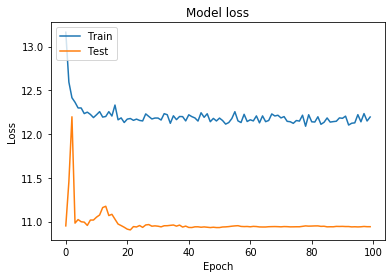

In [75]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
np.expand_dims(embeddings_val[0], axis=0).shape

(1, 21, 53)

In [290]:
idx = 61
print(np.argmax(model.predict(np.expand_dims(embeddings_val[idx], axis=0))[0],axis=1))
print(np.argmax(labels_val[idx], axis=1))

[4 3 3 4 4 4 3 4 3 3 4 3 3 3 4 4 4 4 4 4 4]
[3 4 4 4 2 3 3 2 2 3 3 3 3 3 3 2 3 3 3 3 3]


In [291]:
idx = 61
print(np.argmax(model.predict(embeddings_val), axis=2).flatten().shape)
print(np.argmax(labels_val, axis=2).flatten().shape)
# np.argmax(model.predict(embeddings_val), axis=2).flatten()
# np.argmax(labels_val, axis=2)

(1953,)
(1953,)


In [0]:
x_train = np.array(df_train.feature.values.tolist())
x_train = np.mean(x_train, axis=1)
y_train = np.array(df_train.label.tolist())

x_test = np.array(df_test.feature.values.tolist())
x_test = np.mean(x_test, axis=1)
y_test = np.array(df_test.label.tolist())

In [0]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [90]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))

clf.fit(x_train, y_train)

y_pred=clf.predict(x_train)
print("Train accuracy    :",accuracy_score(y_true=y_train, y_pred=y_pred))

y_pred=clf.predict(x_test)
print("Val accuracy      :",accuracy_score(y_true=y_test, y_pred=y_pred))

Train accuracy    : 0.6992113135708458
Val accuracy      : 0.5072289156626506


In [91]:
from sklearn.metrics import precision_recall_fscore_support

print('Weighted FScore: \n ', precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Weighted FScore: 
  (0.4497574802251602, 0.5072289156626506, 0.47193458194028876, None)


In [94]:
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC())

clf.fit(x_train, y_train)

y_pred=clf.predict(x_train)
print("Train accuracy    :",accuracy_score(y_true=y_train, y_pred=y_pred))

y_pred=clf.predict(x_test)
print("Val accuracy      :",accuracy_score(y_true=y_test, y_pred=y_pred))
print('Weighted FScore: \n ', precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Train accuracy    : 0.6333967908621159
Val accuracy      : 0.6216867469879518
Weighted FScore: 
  (0.38817880216518247, 0.6216867469879518, 0.4779361311416671, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [95]:
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=7))

clf.fit(x_train, y_train)

y_pred=clf.predict(x_train)
print("Train accuracy    :",accuracy_score(y_true=y_train, y_pred=y_pred))

y_pred=clf.predict(x_test)
print("Val accuracy      :",accuracy_score(y_true=y_test, y_pred=y_pred))
print('Weighted FScore: \n ', precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Train accuracy    : 0.641691596410117
Val accuracy      : 0.6060240963855422
Weighted FScore: 
  (0.4797828748147671, 0.6060240963855422, 0.5129072559047266, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=11))

clf.fit(x_train, y_train)

y_pred=clf.predict(x_train)
print("Train accuracy    :",accuracy_score(y_true=y_train, y_pred=y_pred))

y_pred=clf.predict(x_test)
print("Validation accuracy: ",accuracy_score(y_true=y_test, y_pred=y_pred))
print('Weighted FScore: ', precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Train accuracy    : 0.6335327712809355
Validation accuracy:  0.6132530120481928
Weighted FScore:  (0.46985914793574, 0.6132530120481928, 0.49919631613158894, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
